In [1]:
# Dependencies - General Stuff
import sys
import os
import numpy as np
import pandas as pd
import os
from scipy.optimize import curve_fit


# strfpy
from module.strfpy.makePSTH import SpikeResponse
from module.strfpy import findDatasets, preprocSound, strfSetup, trnDirectFit, plotTfrep, calcSegmentedModel
# from strflab import preprocess_sound, srdata2strflab, linInit, strfData, trnDirectFit, strfOpt

import pynwb
from matplotlib import pyplot as plt
# %matplotlib widget
plt.ion();

In [2]:
nwb_file = '/aquila_ssd2/lthomas/songephys_data/OperantEphys/HpiPur2667F/sites/HpiPur2667F_site02_240905_072851_pb_op/HpiPur2667F_site02_240905_072851_pb_op_ks4_lat_250215.nwb'

#nwb_file = '/Users/frederictheunissen/Working Data/OperantEphys/NWB_Files/HpiPur2667F_site02_240905_072851_pb_op_ks4_lat_250215.nwb'
# Load the nwb file
preprocOptions = {} # we'll leave this empty and use default options
nwb_io =  pynwb.NWBHDF5IO(nwb_file, mode='r')
nwb = nwb_io.read()
units = nwb.units.to_dataframe()
# load the good units
good_units = units[units.group == 'good']


In [3]:
# sample a random unit
unit = good_units.sample().iloc[0]
unit = good_units.loc[73]
print("Processing unit: ", unit.name)

Processing unit:  73


In [4]:
def get_mic_data(nwb, trial):
    rate = nwb.acquisition['audio'].rate
    mic_data = nwb.acquisition['audio'].data
    start_id = int(trial.start_time * rate)
    end_id = int(trial.stop_time * rate)
    mic_trial = mic_data[start_id:end_id]
    return mic_trial[:,1], mic_trial[:,0]

In [5]:
# lets take one trial and compare the spectrogram to the spectrogram of the microphone data
# lets get a ranodm trial
trials = nwb.intervals['playback_trials'].to_dataframe()

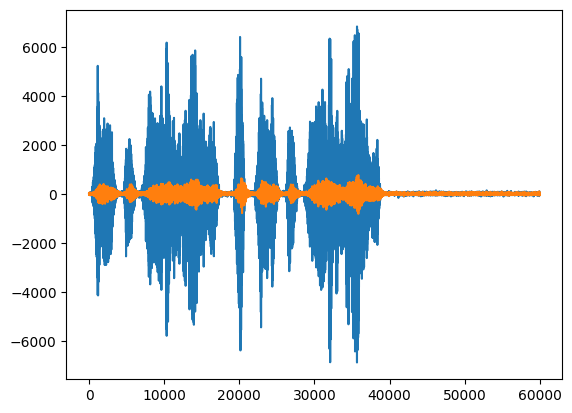

In [6]:

trial = trials.sample().iloc[0]
mic_trial, mic_copy = get_mic_data(nwb, trial)
rate = nwb.acquisition['audio'].rate
plt.figure()
# plt.subplot(2,1,1)
plt.plot(mic_copy)
plt.plot(mic_trial)
# plt.specgram(mic_trial, Fs=rate, NFFT=1024, noverlap=512, cmap='jet')

# plt.subplot(2,1,2)
# plt.specgram(mic_copy, Fs=rate, NFFT=1024, noverlap=512, cmap='jet')

In [10]:
# Preprocess sound stimulus and segment

respChunkLen = 100 # ms of stim to use in each chunk of feature space
segmentBuffer = 30 # ms to add at the beginning of each segment
nLaguerre = 25 # number of laguerre functions to use
feature = 'spect_windows'
event_types = 'onoff_feature'
nPoints = 150 # number of points to use in the kernel
mult_values = False
srData = preprocSound.preprocess_sound_nwb(nwb_file, 'playback_trials', unit.name, preprocess_type='ft')
calcSegmentedModel.preprocess_srData(srData, plot=False, respChunkLen=respChunkLen, segmentBuffer=segmentBuffer, tdelta=0, plotFlg = False)


              kilosort_dir  kilosort_id group        ks_x       ks_y  \
id                                                                     
73  ks4_lat_250215/shank_1           75  good  162.010559  50.489616   

                                          spike_times electrodes  
id                                                                
73  [0.06543333333333333, 0.10373333333333333, 0.1...       [30]  


/auto/zdrive/lthomas/Code/strfPY/module/strfpy/timeFreq.py:29: RuntimeWarning: divide by zero encountered in log10
  normedS = 20 * np.log10(normedS)


A colormap named "SpectroColorMap" is already registered.


In [11]:
# SINGLE TRIAL 
srData_st = preprocSound.generate_srData_nwb_single_trials(nwb, 'playback_trials',unit.name)
calcSegmentedModel.preprocess_srData(srData_st, plot=False, respChunkLen=respChunkLen, segmentBuffer=segmentBuffer, tdelta=0, plotFlg = False, seg_spec_lookup = nwb.processing['stimuli_spectrograms'])

In [7]:
# Calculate the average response at onsets and offsets

meansOnOff = np.zeros((2,nPoints))
nEventsOnOff = np.zeros((2,1))
responseAvg = 0
stimLenTot = 0
for ds in srData['datasets']:
    events = ds['events']
    nEvents = len(events['index'])
    stimLen = ds['resp']['psth_smooth'].shape[0]
    responseAvg += np.sum(ds['resp']['psth_smooth'])
    stimLenTot += stimLen
    for iEvent in range(nEvents):
        startInd = events['index'][iEvent]
        endInd = startInd + nPoints
        if (endInd>stimLen):
            endInd = stimLen
        if (events['onoff_feature'][iEvent][0] == 1 ):
            meansOnOff[0,0:endInd-startInd] = meansOnOff[0,0:endInd-startInd] + ds['resp']['psth_smooth'][startInd:endInd]
            nEventsOnOff[0] += 1
        else:
            meansOnOff[1,0:endInd-startInd] = meansOnOff[1,0:endInd-startInd] + ds['resp']['psth_smooth'][startInd:endInd]
            nEventsOnOff[1] += 1

meansOnOff[0,:] /= nEventsOnOff[0]
meansOnOff[1,:] /= nEventsOnOff[1]
responseAvg /= stimLenTot

meansOnOff[0,:] -= responseAvg
meansOnOff[1,:] -= responseAvg




In [8]:
# Calculate the segmented encoding models for spectrograms and Laguerre.
srData, pcaFeatures, ridgeSI, ridgeS, laguerre_args, r2s = calcSegmentedModel.process_unit(srData, feature=feature, nLaguerre=nLaguerre,nPoints=nPoints,  LOO=True)
results = dict({
    'uid': [unit.name],
    'model': ['Seg_LogSpect_Laguerre'],
    'pca': [pcaFeatures],
    'Seg_Ind': [ridgeSI],
    'Seg': [ridgeS],
    'basis_args': [laguerre_args],
    'r2_seg': [r2s[1]],
    'r2_segid': [r2s[3]],
})

Fitting PCA to Feature
Fitting convolutional kernel
Fitting laguerre or DOGS parameters
Fitting Laguerre parameters
Fit the laguerre convolved features to the response
Fitting PCA to Feature
Fitting convolutional kernel
Fitting laguerre or DOGS parameters
Fitting Laguerre parameters
Fit the laguerre convolved features to the response
Fitting PCA to Feature
Fitting convolutional kernel
Fitting laguerre or DOGS parameters
Fitting Laguerre parameters
Fit the laguerre convolved features to the response
Fitting PCA to Feature
Fitting convolutional kernel
Fitting laguerre or DOGS parameters
Fitting Laguerre parameters
Fit the laguerre convolved features to the response
Fitting PCA to Feature
Fitting convolutional kernel
Fitting laguerre or DOGS parameters
Fitting Laguerre parameters
Fit the laguerre convolved features to the response
Fitting PCA to Feature
Fitting convolutional kernel
Fitting laguerre or DOGS parameters
Fitting Laguerre parameters
Fit the laguerre convolved features to the r

In [9]:
print('R2 for seg Train/Test', r2s[0], r2s[1])
print('R2 for seg+id: Train/Test', r2s[2], r2s[3])

R2 for seg Train/Test 0.12610248686281147 0.1168523089187346
R2 for seg+id: Train/Test 0.3783301700764551 0.2810621973136287


In [18]:
# Calculate the segmented encoding models for spectrograms and DOGS.
srData, pca, ridgeSI, ridgeS, dogs_args, r2s = calcSegmentedModel.process_unit(srData, feature=feature, nLaguerre=-1,nPoints=nPoints,  LOO=True)

results['pca'].append(pca)
results['uid'].append(unit.name)
results['model'].append('Seg_LogSpect_DOGS')
results['Seg_Ind'].append(ridgeSI)
results['Seg'].append(ridgeS)
results['basis_args'].append(dogs_args)
results['r2_seg'].append(r2s[1])
results['r2_segid'].append(r2s[3])

Fitting PCA to Feature
Fitting convolutional kernel
Fitting laguerre or DOGS parameters
Fitting DOGS parameters
Fit the laguerre convolved features to the response
Fitting PCA to Feature
Fitting convolutional kernel
Fitting laguerre or DOGS parameters
Fitting DOGS parameters
Fit the laguerre convolved features to the response
Fitting PCA to Feature
Fitting convolutional kernel
Fitting laguerre or DOGS parameters
Fitting DOGS parameters
Fit the laguerre convolved features to the response
Fitting PCA to Feature
Fitting convolutional kernel
Fitting laguerre or DOGS parameters
Fitting DOGS parameters
Fit the laguerre convolved features to the response
Fitting PCA to Feature
Fitting convolutional kernel
Fitting laguerre or DOGS parameters
Fitting DOGS parameters
Fit the laguerre convolved features to the response
Fitting PCA to Feature
Fitting convolutional kernel
Fitting laguerre or DOGS parameters
Fitting DOGS parameters
Fit the laguerre convolved features to the response
Fitting PCA to F

In [19]:
print('R2 for seg Train/Test', r2s[0], r2s[1])
print('R2 for seg+id: Train/Test', r2s[2], r2s[3])

R2 for seg Train/Test 0.12610248686281147 0.1168523089187346
R2 for seg+id: Train/Test 0.369248792213994 0.28375371816330297


In [12]:
events = srData['datasets'][0]['events']
nf = events['spect_windows'].shape[1]
nt = events['spect_windows'].shape[2]
tfrep = srData['datasets'][0]['stim']['tfrep']
npcs = pca.n_components_


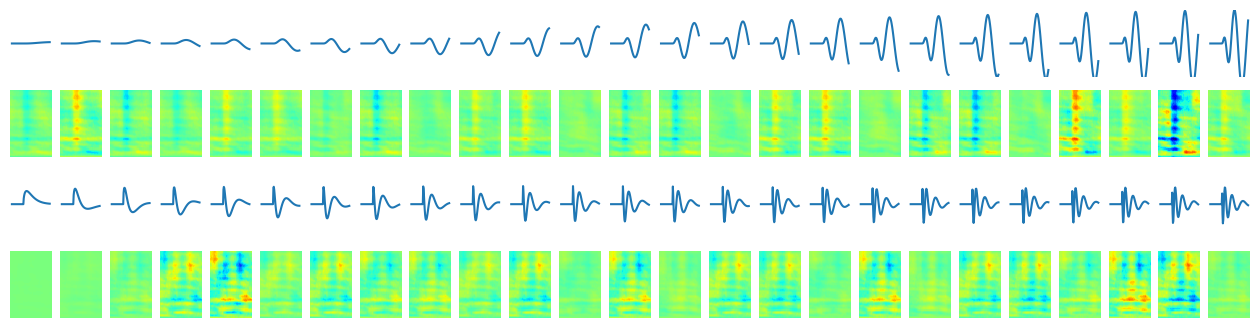

In [13]:
# Plot the On and Off filters for Laguerre Fit

plt.figure(figsize=(16, 4), dpi=100)
strfLGOn = np.zeros((nLaguerre, nf, nt))
strfLGOff = np.zeros((nLaguerre, nf, nt))
x_t = np.arange(nt-segmentBuffer)
x_plot = np.arange(nt)-segmentBuffer

for iL in range(nLaguerre):
    istart = 2*npcs*iL
    iend = istart+npcs
    strfLGOn[iL,:,:] = np.dot(results['Seg_Ind'][0].coef_[istart:iend], results['pca'][0].components_).reshape((nf,nt))
    strfLGOff[iL,:,:] = np.dot(results['Seg_Ind'][0].coef_[istart+npcs:iend+npcs], results['pca'][0].components_).reshape((nf,nt))



maxSTRFOn = np.max((np.max(strfLGOn), np.abs(np.min(strfLGOn))))
maxSTRFOff = np.max((np.max(strfLGOff), np.abs(np.min(strfLGOff))))
maxSTRF = np.max((maxSTRFOn,maxSTRFOff))
                 
for iL in range(nLaguerre):
    yOn = np.zeros(nt)
    yOn[segmentBuffer:] = calcSegmentedModel.laguerre(
        x_t,
        amp=1.0,
        tau=results['basis_args'][0][0,0],
        alpha=results['basis_args'][0][0,1],
        xorder=iL,
        )
    # yOn = yOn / np.sqrt(np.sum(yOn**2))
    yOff = np.zeros(nt)
    yOff[segmentBuffer:] = calcSegmentedModel.laguerre(
        x_t,
        amp=1.0,
        tau=results['basis_args'][0][1,0],
        alpha=results['basis_args'][0][1,1],
        xorder=iL,
        )
    # yOff = yOff / np.sqrt(np.sum(yOff**2))
    plt.subplot(4,  nLaguerre, iL+1)
    plt.plot(x_plot,yOn)
    plt.ylim((-50,50))
    plt.axis('off')
    plt.subplot(4,  nLaguerre, 2*nLaguerre+iL+1)
    plt.plot(x_plot,yOff)
    plt.ylim((-1,1))
    plt.axis('off')
    plt.subplot(4, nLaguerre, nLaguerre+iL+1)
    plt.imshow(strfLGOn[iL,:,:], extent=[0, 100, tfrep['f'][0]*1e-3, tfrep['f'][-1]*1e-3],
                aspect='auto', interpolation='nearest', origin='lower', cmap='jet', vmin=-maxSTRF, vmax=maxSTRF)
    plt.axis('off')
    plt.subplot(4, nLaguerre, 3*nLaguerre+iL+1)
    plt.imshow(strfLGOff[iL,:,:], extent=[0, 100, tfrep['f'][0]*1e-3, tfrep['f'][-1]*1e-3],
                aspect='auto', interpolation='nearest', origin='lower', cmap='jet', vmin=-maxSTRF, vmax=maxSTRF)
    plt.axis('off')



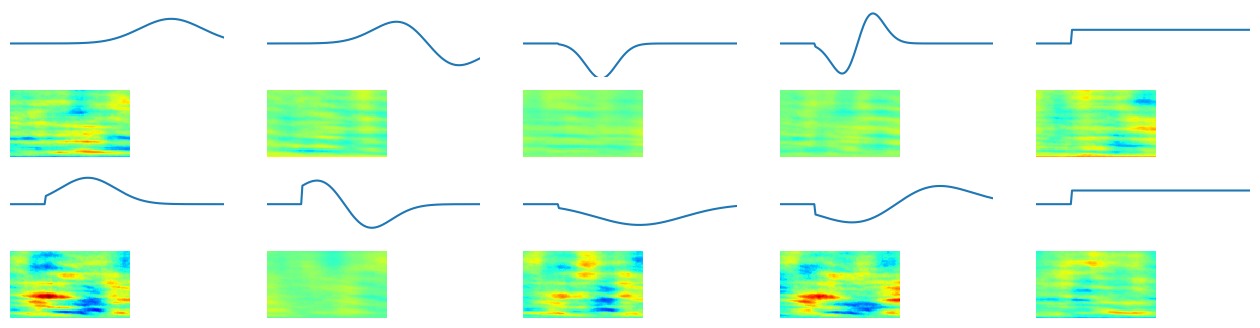

In [14]:
# Plot the On and Off filters for the DOGS Fit

plt.figure(figsize=(16, 4), dpi=100)
strfLGOn = np.zeros((nLaguerre, nf, nt))
strfLGOff = np.zeros((nLaguerre, nf, nt))
x_t = np.arange(nPoints)
x_plot = np.arange(nPoints+segmentBuffer)-segmentBuffer

nDOGS = 5
for iD in range(nDOGS):
    istart = 2*npcs*iD
    iend = istart+npcs
    strfLGOn[iD,:,:] = np.dot(results['Seg_Ind'][1].coef_[istart:iend], results['pca'][1].components_).reshape((nf,nt))
    strfLGOff[iD,:,:] = np.dot(results['Seg_Ind'][1].coef_[istart+npcs:iend+npcs], results['pca'][1].components_).reshape((nf,nt))



maxSTRFOn = np.max((np.max(strfLGOn), np.abs(np.min(strfLGOn))))
maxSTRFOff = np.max((np.max(strfLGOff), np.abs(np.min(strfLGOff))))
maxSTRF = np.max((maxSTRFOn,maxSTRFOff))

meanValOn, ampPosOn, ampNegOn, tPosOn, tNegOn, sdPosOn, sdNegOn = results['basis_args'][1][0]   
meanValOff, ampPosOff, ampNegOff, tPosOff, tNegOff, sdPosOff, sdNegOff = results['basis_args'][1][1]                
for iD in range(nDOGS):
    yOn = np.zeros(nPoints+segmentBuffer) 
    yOff = np.zeros(nPoints+segmentBuffer)           
    if (iD == 0) :
        yOn[segmentBuffer:] = calcSegmentedModel.Gauss(x_t, tPosOn, sdPosOn)
        yOff[segmentBuffer:] = calcSegmentedModel.Gauss(x_t, tPosOff, sdPosOff)
    elif (iD == 1) : 
        yOn[segmentBuffer:] = calcSegmentedModel.DGauss(x_t, tPosOn, sdPosOn)
        yOff[segmentBuffer:] = calcSegmentedModel.DGauss(x_t, tPosOff, sdPosOff)
    elif (iD == 2) : 
        yOn[segmentBuffer:] = -calcSegmentedModel.Gauss(x_t, tNegOn, sdNegOn)
        yOff[segmentBuffer:] = -calcSegmentedModel.Gauss(x_t, tNegOff, sdNegOff)
    elif (iD ==3) :
        yOn[segmentBuffer:] = -calcSegmentedModel.DGauss(x_t, tNegOn, sdNegOn)
        yOff[segmentBuffer:] = -calcSegmentedModel.DGauss(x_t, tNegOff, sdNegOff)
    elif (iD == 4):
        yOn[segmentBuffer:] = np.ones(nPoints)
        yOff[segmentBuffer:] = np.ones(nPoints)
    
    yOn = yOn / np.sqrt(np.sum(yOn**2))
    yOff = yOff / np.sqrt(np.sum(yOff**2))

    plt.subplot(4,  nDOGS, iD+1)
    plt.plot(x_plot,yOn)
    plt.xlim([x_plot.min(), x_plot.max()])
    plt.ylim((-0.2,0.2))
    plt.axis('off')
    plt.subplot(4,  nDOGS, 2*nDOGS+iD+1)
    plt.plot(x_plot,yOff)
    plt.xlim([x_plot.min(), x_plot.max()])
    plt.ylim((-0.2,0.2))
    plt.axis('off')
    plt.subplot(4, nDOGS, nDOGS+iD+1)
    plt.imshow(strfLGOn[iD,:,:], extent=[-segmentBuffer, nt-segmentBuffer, tfrep['f'][0]*1e-3, tfrep['f'][-1]*1e-3],
                aspect='auto', interpolation='nearest', origin='lower', cmap='jet', vmin=-maxSTRF, vmax=maxSTRF)
    plt.xlim([x_plot.min(), x_plot.max()])
    plt.axis('off')
    plt.subplot(4, nDOGS, 3*nDOGS+iD+1)
    plt.imshow(strfLGOff[iD,:,:], extent=[-segmentBuffer, nt-segmentBuffer, tfrep['f'][0]*1e-3, tfrep['f'][-1]*1e-3],
                aspect='auto', interpolation='nearest', origin='lower', cmap='jet', vmin=-maxSTRF, vmax=maxSTRF)
    plt.xlim([x_plot.min(), x_plot.max()])
    plt.axis('off')



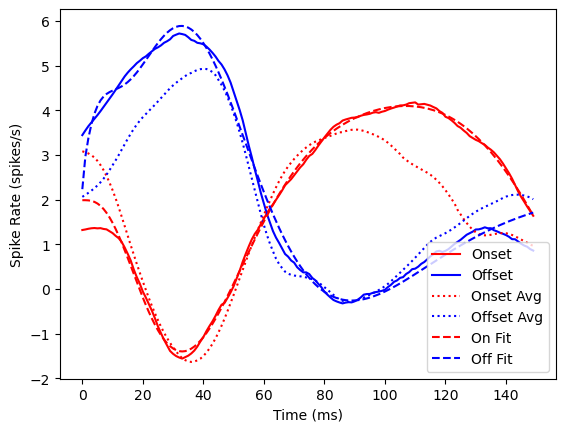

In [15]:
# Plot the segmented Kernels for this neuron and the laguerre fits
kernels = results['Seg'][0].coef_.reshape((2,nPoints))
nt = kernels.shape[1]
x_t = np.arange(nt)
laguerre_args = results['basis_args'][0]
nLGFit = laguerre_args.shape[1]-2
yOnFit = np.ones(nt)*np.mean(kernels[0,:])
for iLG in range(nLGFit):
        yOnFit += calcSegmentedModel.laguerre(x_t, amp=laguerre_args[0,2+iLG], tau=laguerre_args[0,0], alpha=laguerre_args[0,1], xorder=iLG)

yOffFit = np.ones(nt)*np.mean(kernels[1,:])
for iLG in range(nLGFit):
        yOffFit += calcSegmentedModel.laguerre(x_t, amp=laguerre_args[1,2+iLG], tau=laguerre_args[1,0], alpha=laguerre_args[1,1], xorder=iLG)

plt.plot(kernels[0,:], 'r', label='Onset')
plt.plot(kernels[1,:], 'b', label='Offset')
plt.plot(meansOnOff[0,:], 'r:', label='Onset Avg')
plt.plot(meansOnOff[1,:], 'b:', label='Offset Avg')
plt.plot(yOnFit, 'r--', label='On Fit')
plt.plot(yOffFit, 'b--', label='Off Fit')
plt.xlabel('Time (ms)')
plt.ylabel('Spike Rate (spikes/s)')
plt.legend()

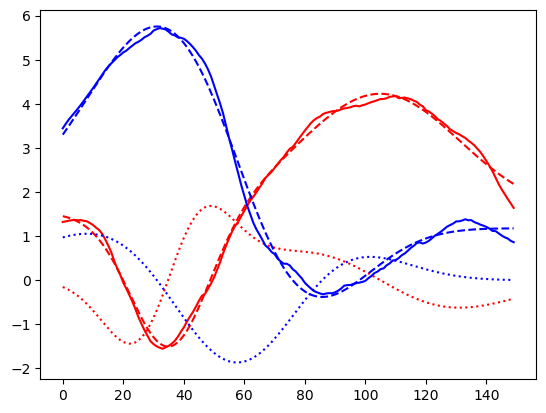

In [16]:
# Let's try fitting with DOGS.

def dogs(xt, meanVal, ampPos, ampNeg, tPos, tNeg, sdPos, sdNeg):
            
    out = np.zeros_like(xt, dtype=float)
    out = meanVal + ampPos*np.exp(-0.5*(xt-tPos)**2/sdPos**2) - ampNeg*np.exp(-0.5*(xt-tNeg)**2/sdNeg**2)
    return out

def dDogsDt(xt, meanVal, ampPos, ampNeg, tPos, tNeg, sdPos, sdNeg):
            
    out = np.zeros_like(xt, dtype=float)
    out = -ampPos*((xt-tPos)/(sdPos**2))*np.exp(-0.5*(xt-tPos)**2/sdPos**2) + ampNeg*((xt-tNeg)/(sdNeg**2))*np.exp(-0.5*(xt-tNeg)**2/sdNeg**2)
    return out

# Find starting points
meanVal = np.mean(kernels[0,:])
ampPos = np.max(kernels[0,:])-meanVal
tPos = np.argmax(kernels[0,:])
ampNeg = np.abs(np.min(kernels[0,:])-meanVal)
tNeg = np.argmin(kernels[0,:])
sdPos = sdNeg = 20
p0=[meanVal, ampPos, ampNeg, tPos, tNeg, sdPos, sdNeg]



poptOn, pcovOn = curve_fit(
            dogs,
            np.arange(nt), kernels[0,:], p0,
            bounds=(
                [np.min(kernels[0,:]), 0, 0, 0, 0, 0, 0],
                [np.max(kernels[0,:]), np.inf, np.inf, nt, nt, nt, nt],
            ),
            method="trf",
        )
yOnDOGFit = dogs(np.arange(nt), *poptOn)
yOnDDOGFit = dDogsDt(np.arange(nt), *poptOn)

meanVal = np.mean(kernels[1,:])
ampPos = np.max(kernels[1,:])-meanVal
tPos = np.argmax(kernels[1,:])
ampNeg = np.abs(np.min(kernels[1,:])-meanVal)
tNeg = np.argmin(kernels[1,:])
sdPos = sdNeg = 20
p0=[meanVal, ampPos, ampNeg, tPos, tNeg, sdPos, sdNeg]



poptOff, pcovOff = curve_fit(
            dogs,
            np.arange(nt), kernels[1,:], p0,
            bounds=(
                [np.min(kernels[1,:]), 0, 0, 0, 0, 0, 0],
                [np.max(kernels[1,:]), np.inf, np.inf, nt, nt, nt, nt],
            ),
            method="trf",
        )
yOffDOGFit = dogs(np.arange(nt), *poptOff)
yOffDDOGFit = dDogsDt(np.arange(nt), *poptOff)

plt.figure()
plt.plot(kernels[0,:], 'r', label='Onset')
plt.plot(yOnDOGFit, 'r--', label='On Fit')
plt.plot(10.0*yOnDDOGFit, 'r:', label='On Derivative')
plt.plot(kernels[1,:], 'b', label='Offset')
plt.plot(yOffDOGFit, 'b--', label='Off Fit')
plt.plot(10.0*yOffDDOGFit, 'b:', label='Off Derivative')



/var/folders/st/czd2s3fn20q2nbmgdybh35nh0000gn/T/ipykernel_52507/2671351544.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, dpi=100, figsize = (8,4))


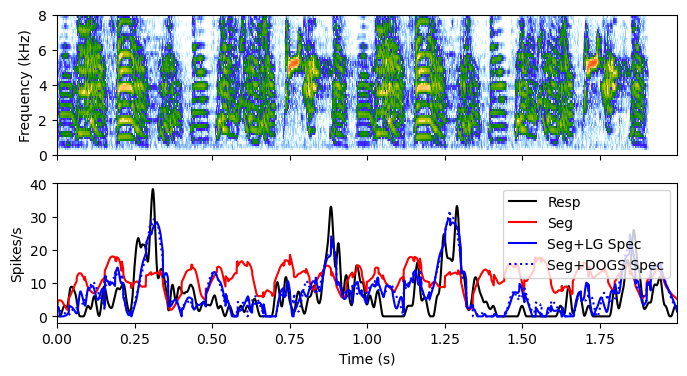

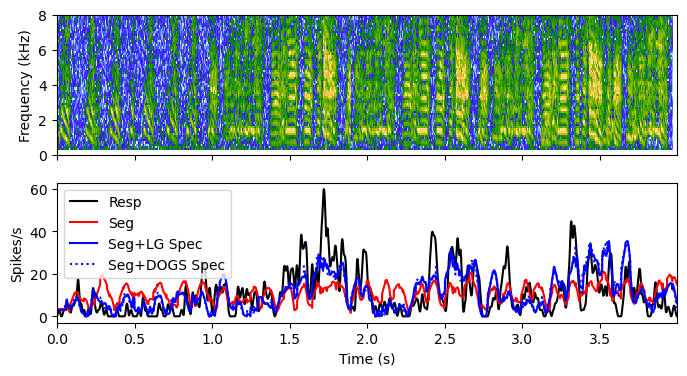

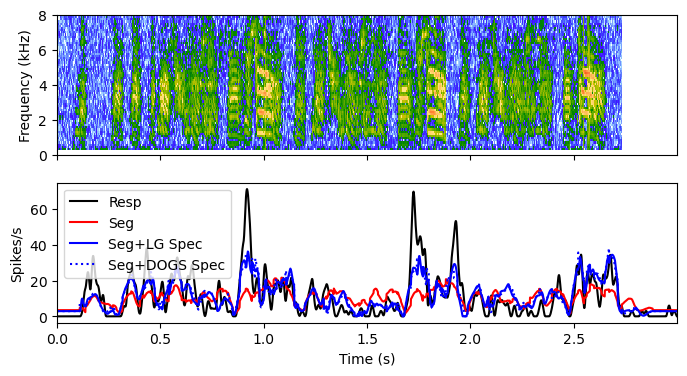

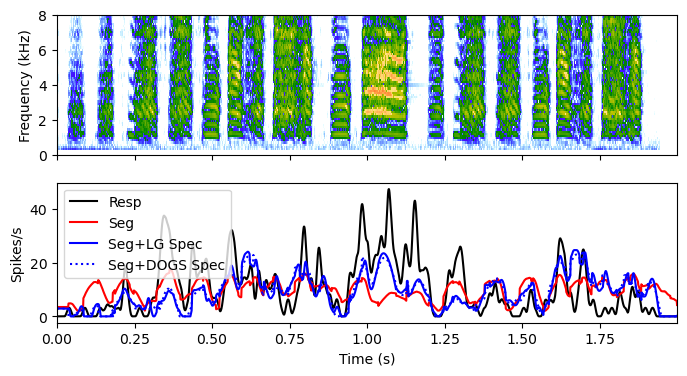

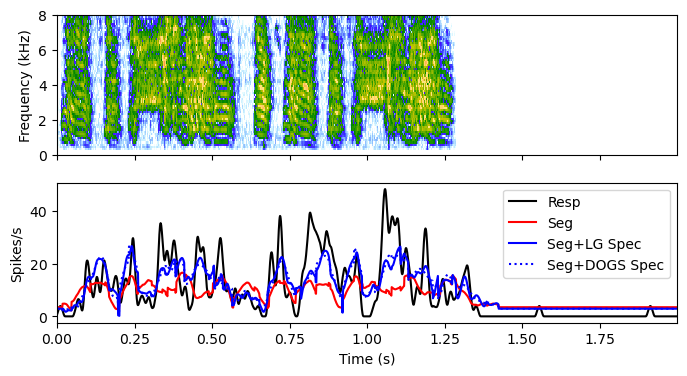

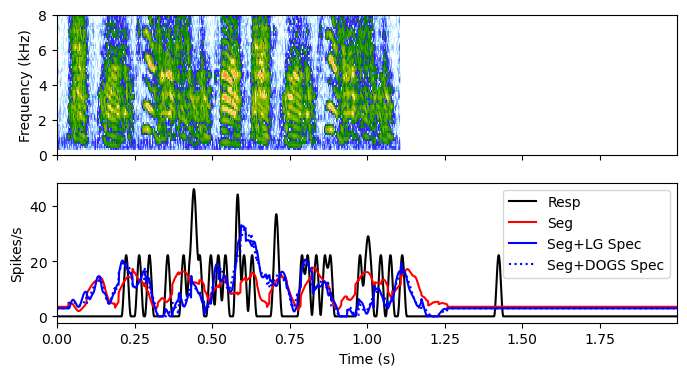

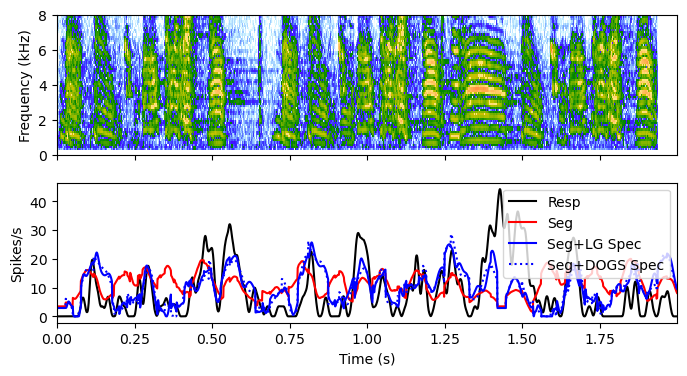

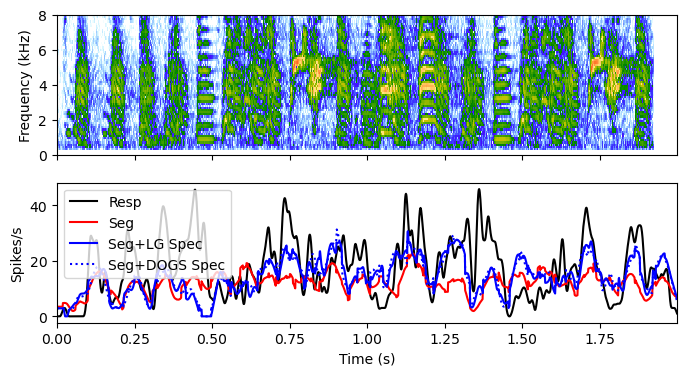

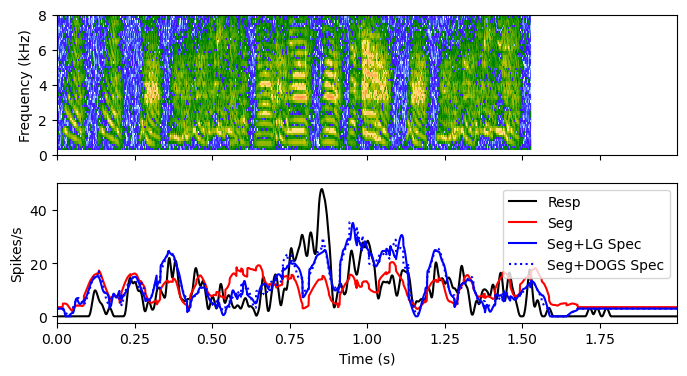

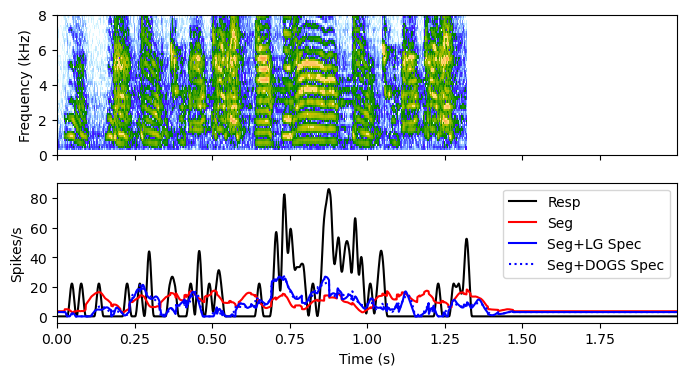

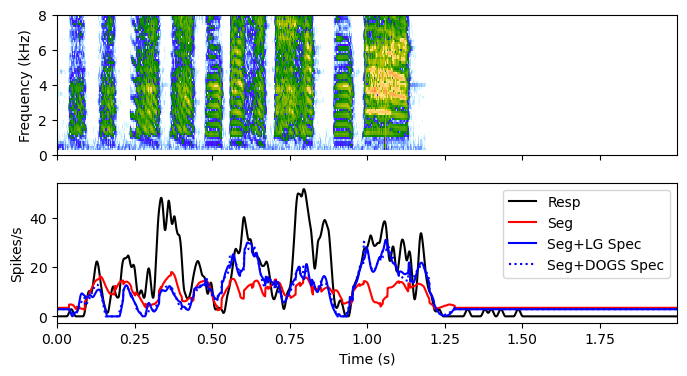

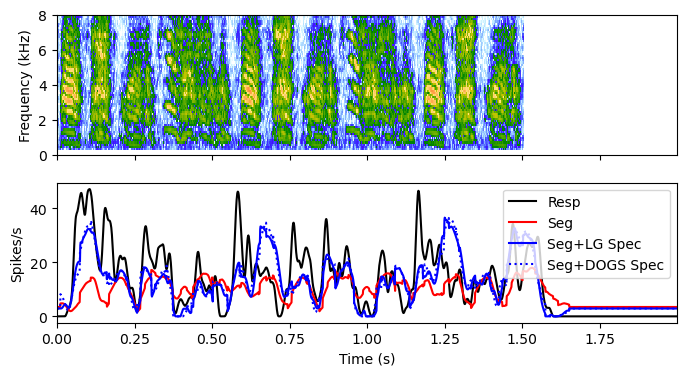

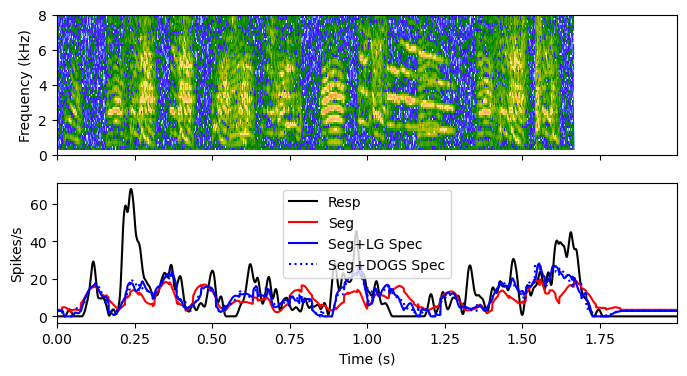

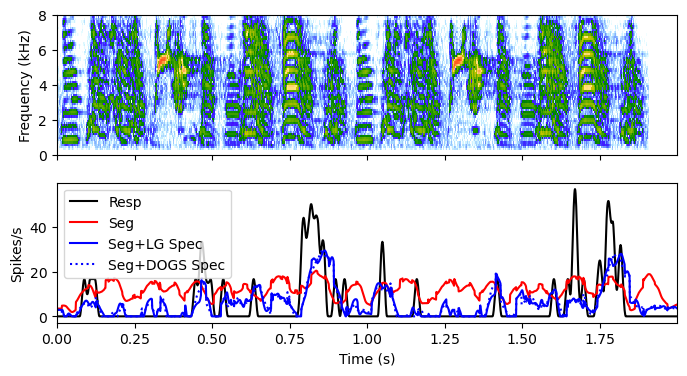

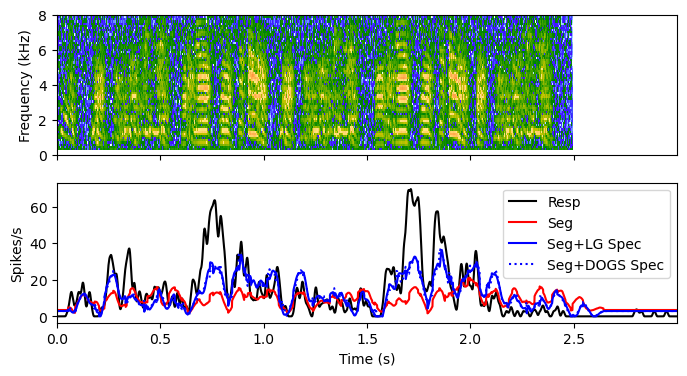

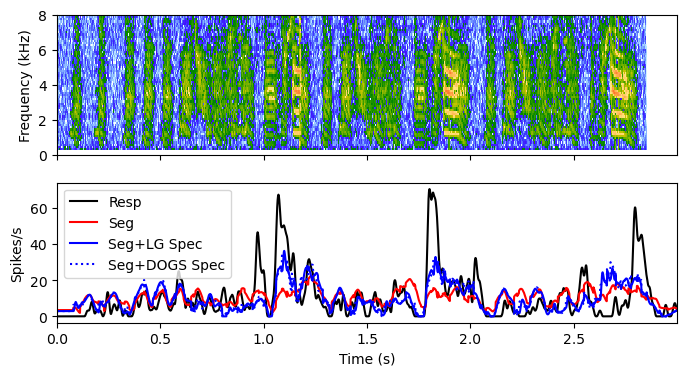

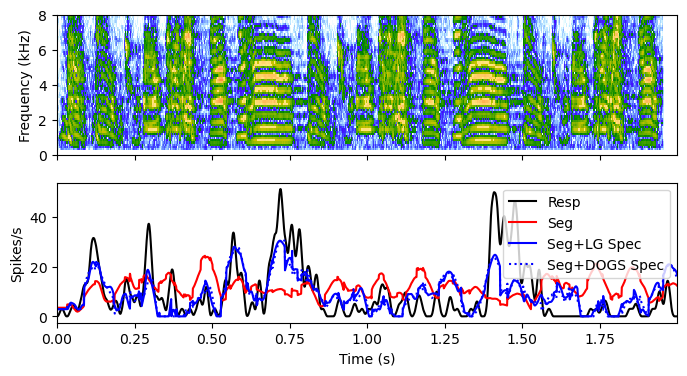

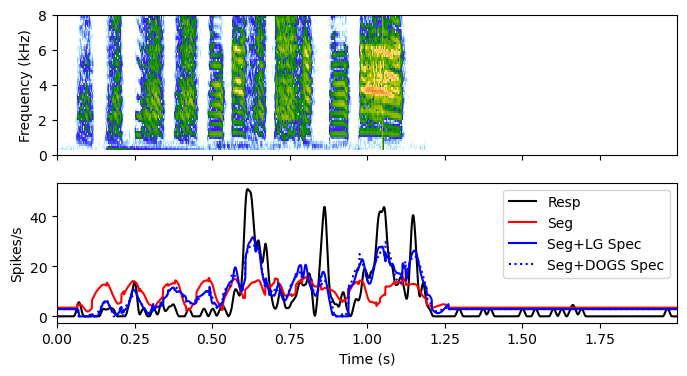

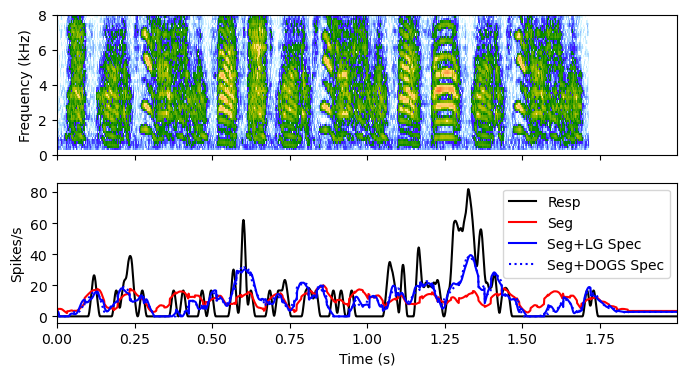

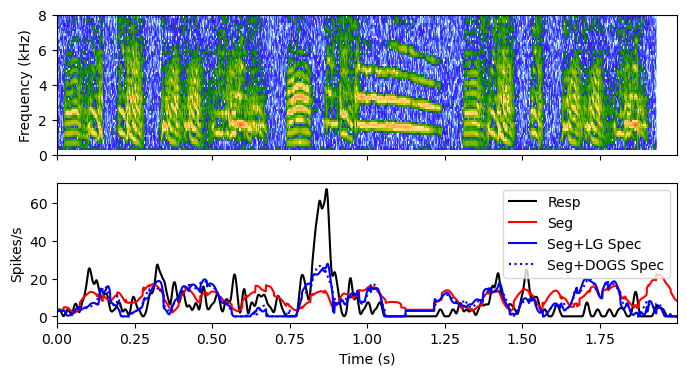

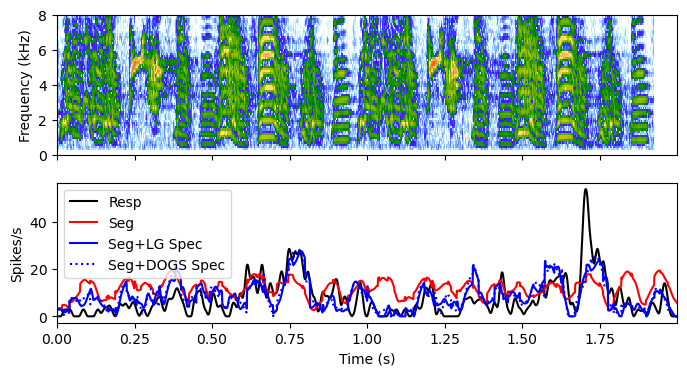

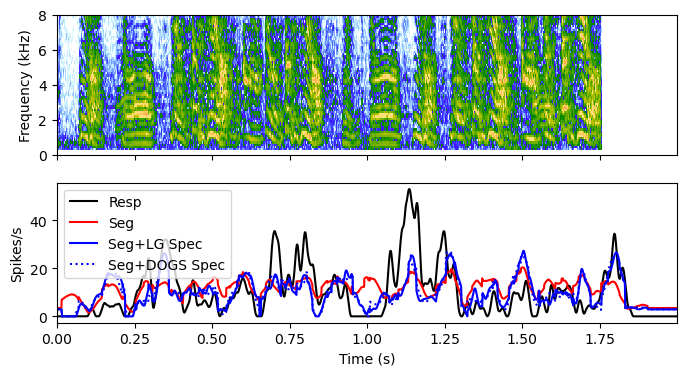

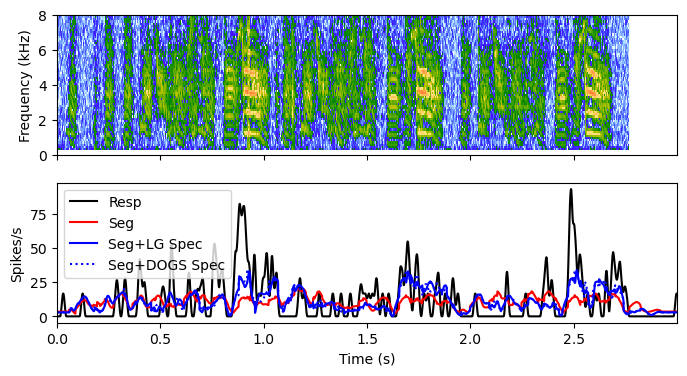

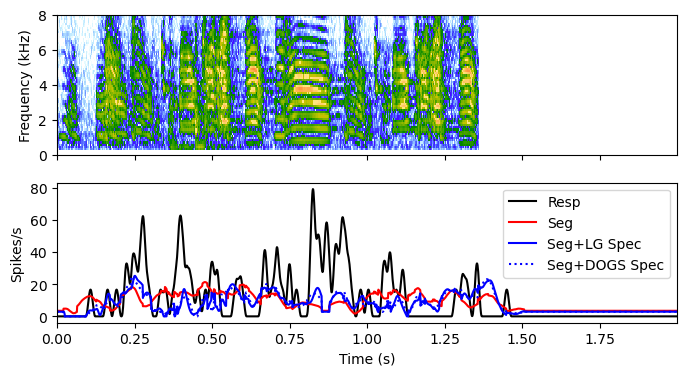

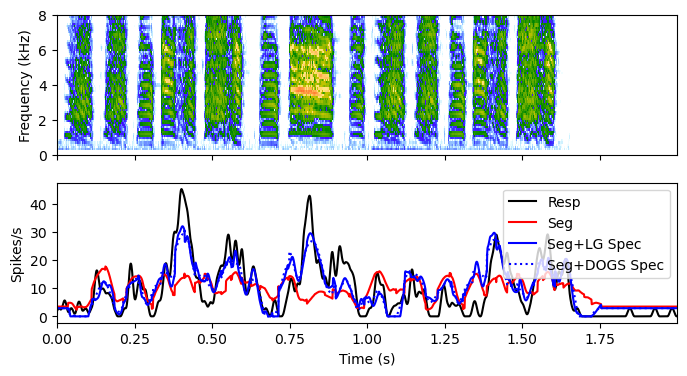

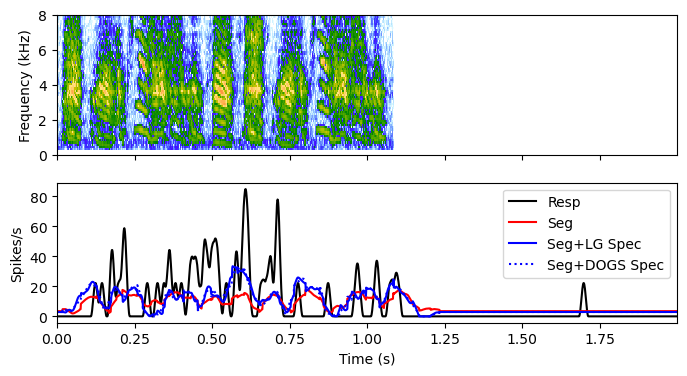

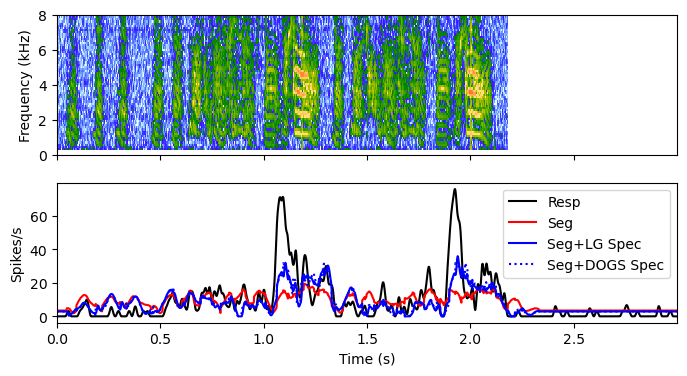

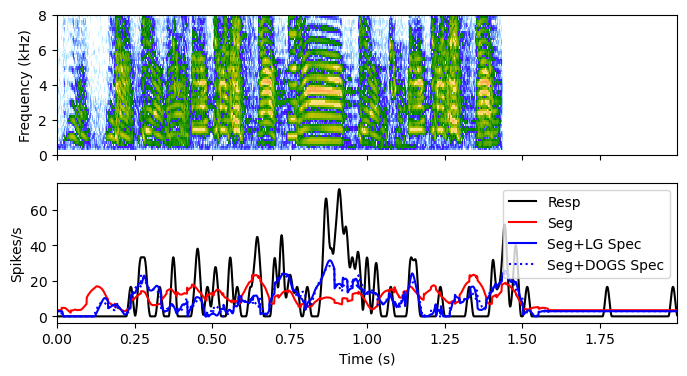

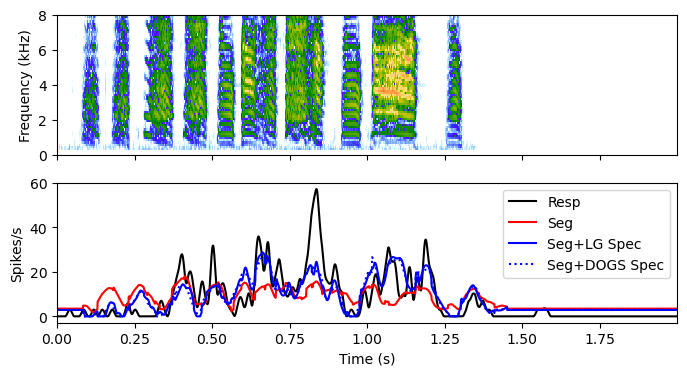

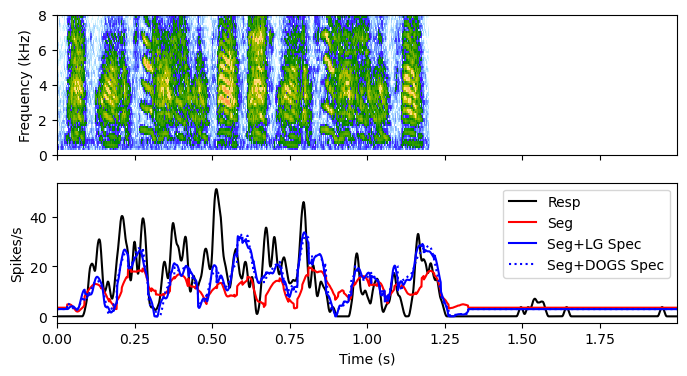

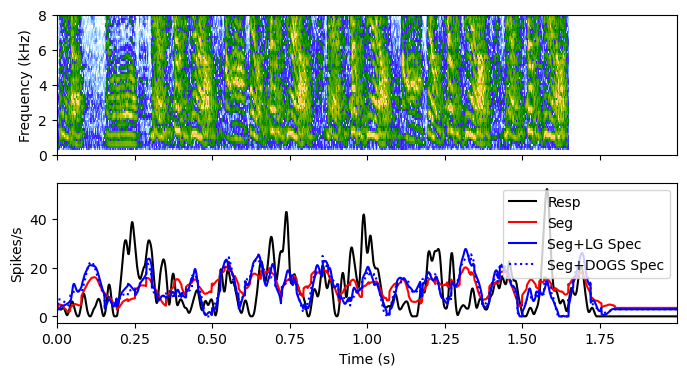

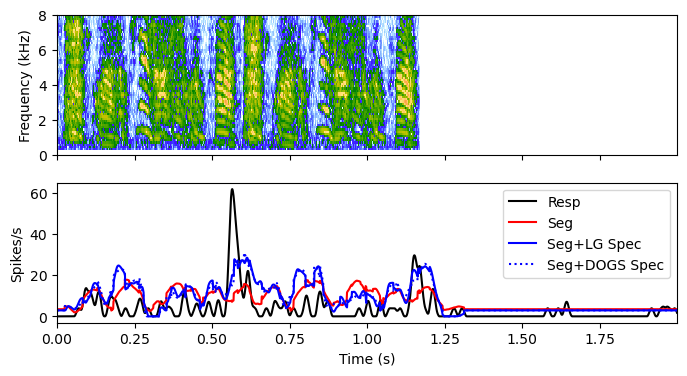

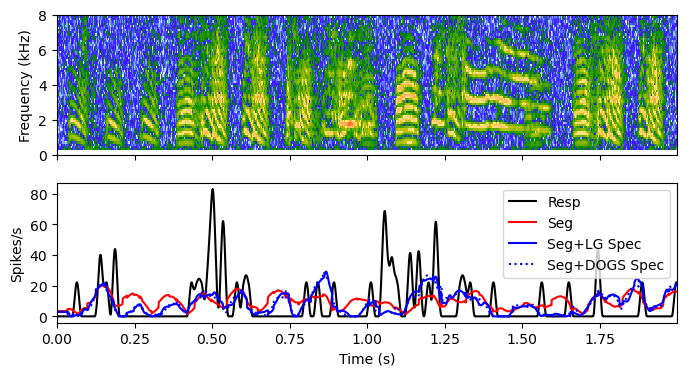

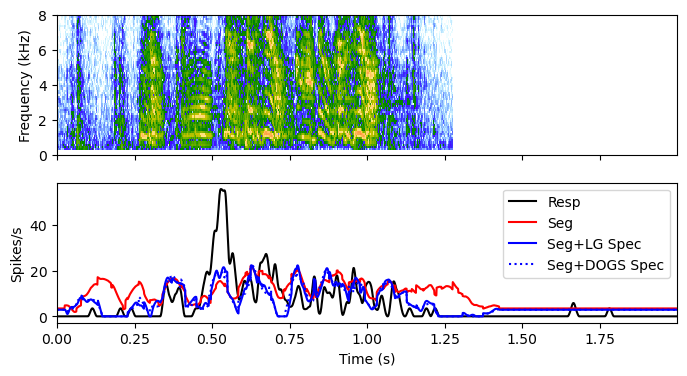

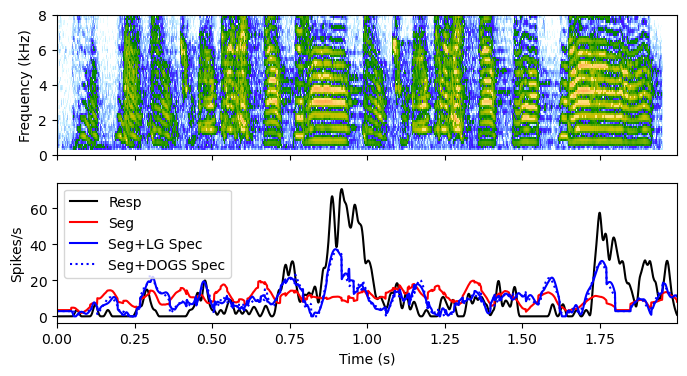

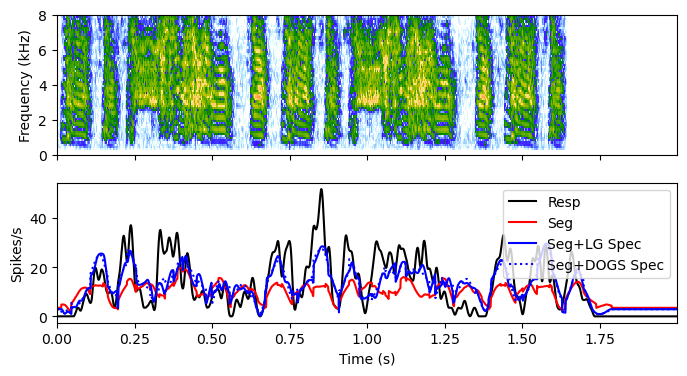

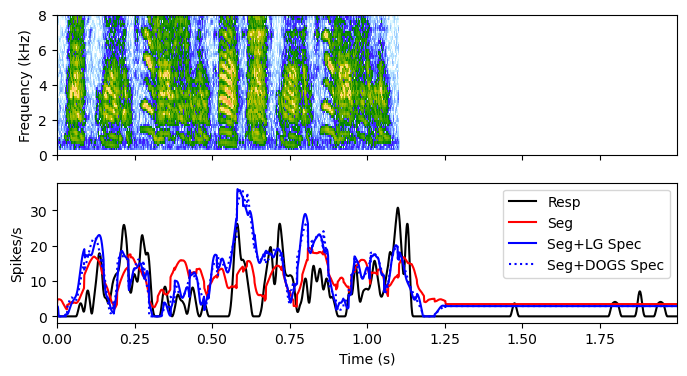

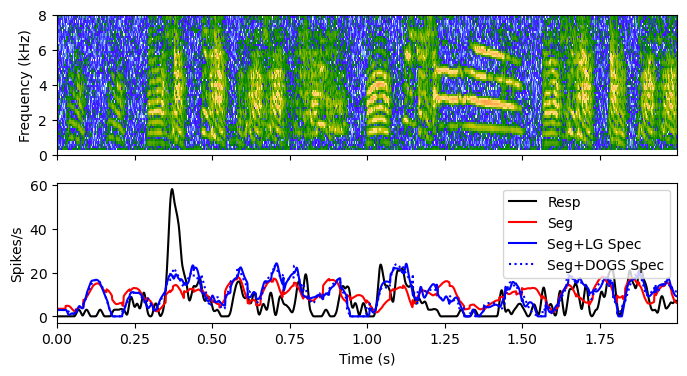

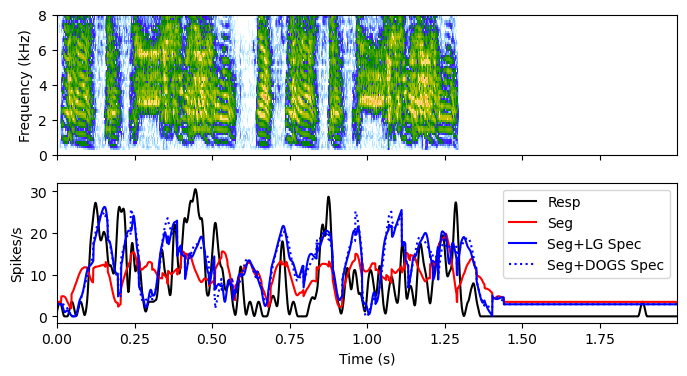

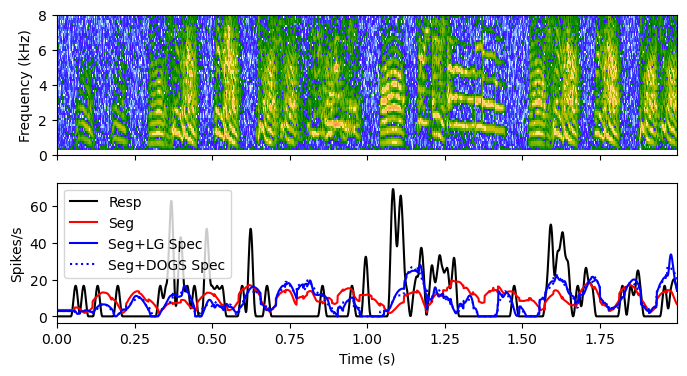

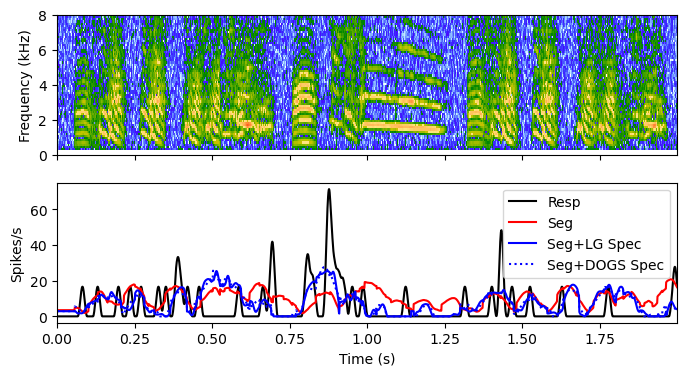

In [17]:
# Show all the results
DBNOISE = 80 # should match value in preprocSound
for pair in srData['datasets']:

    y = pair['resp']['psth_smooth']

    # get the pred for the seg only version
    x = calcSegmentedModel.arbitrary_kernel(pair, nPoints=nPoints, resp_key='psth')
    y_pred_1 = results['Seg'][0].predict(x.T)


    # get the pred for the full version
    y_pred_2 = calcSegmentedModel.generate_prediction(
        pair, results['Seg_Ind'][0], feature, results['basis_args'][0], nPoints, nLaguerre
    )
    y_pred_3 = calcSegmentedModel.generate_prediction(
        pair, results['Seg_Ind'][1], feature, results['basis_args'][1], nPoints, -1
    )

    
    # The spectrogram
    tfrep = pair['stim']['tfrep']
    minSpect = 0
    maxB = DBNOISE

    # Plot the spectrogram and the prediction
    f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, dpi=100, figsize = (8,4))
    cmap = plt.get_cmap('SpectroColorMap')
    ax1.imshow(tfrep['spec'], extent=[tfrep['t'][0], tfrep['t'][-1], tfrep['f'][0]*1e-3, tfrep['f'][-1]*1e-3],
                aspect='auto', interpolation='nearest', origin='lower', cmap=cmap, vmin=minSpect, vmax=maxB)
    ax1.set_ylim(0, 8)
    ax1.set_ylabel('Frequency (kHz)')
    # ax1.set_xlabel('Time (s)')

    # The prediction
    numTrials = len(pair['resp']['rawSpikeTimes'])
    # fac = pair['resp']['sampleRate']/numTrials   # The psth and the responses are already normalized in preprocSound.py
    ax2.plot(tfrep['t'], y, 'k', label='Resp')
    ax2.plot(tfrep['t'], y_pred_1, 'r', label='Seg')
    ax2.plot(tfrep['t'], y_pred_2, 'b', label='Seg+LG Spec')
    ax2.plot(tfrep['t'], y_pred_3, 'b:', label='Seg+DOGS Spec')
    ax2.set_ylabel('Spikes/s')
    ax2.set_xlabel('Time (s)')
    plt.legend()

